# Dataset

In [2]:
import numpy as np
import os
import cv2
import sys

try:
    if global_run_tests: 
        pass 
except: 
    global_run_tests = True
_ds_rt = global_run_tests
global_run_tests = False

%run visualisation.ipynb

global_run_tests = _ds_rt

_dataset_path = "/netforge/datasets/private/roman/coins/images"

In [3]:
class Dataset:
    def __init__(self, image_shape):
        self.image_shape  = image_shape
        self.train_images = []
        self.test_images  = []
        self.data_size    = 0

    def load(self, path, data_size):
        files  = os.listdir(path)[:2*data_size]
        file_num = len(files)
        assert file_num >= data_size, "%s %s" % (file_num, data_size)

        h, w, c = self.image_shape
        images = np.zeros([file_num, h, w, c])

        for i,f in enumerate(files):
            f = os.path.join(path, f)
            im = cv2.imread(f)
            if c == 1:
                im = np.max(im, axis=2)
            im = cv2.resize(im, (w,h), interpolation = cv2.INTER_CUBIC).astype('float32')
            im = np.reshape(im, [h,w,c])
            images[i] = im / (im.max()+1e-6)

        self.path         = path
        self.data_size    = data_size
        self.train_images = images[:data_size]
        self.test_images  = images[-data_size:]
        
        return self.train_images, self.test_images, file_num
    
    def get_next_batch(self, bs, aug_func):
        data = self.train_images
        idx1 = np.random.choice(np.arange(len(data)), bs)
        idx2 = np.random.choice(np.arange(len(data)), bs)

        img1  = data[idx1]
        img2  = data[idx2]
        label = np.zeros([bs,2])
        same  = np.random.randint(2, size=bs)

        aug = aug_func or (lambda im: im)
        for i in range(bs):
            label[i,same[i]] = 1.
            if same[i]:
                img2[i] = aug(img1[i])
                img1[i] = aug(img1[i])
            else:
                img1[i] = aug(img1[i])
                img2[i] = aug(img2[i])

        return img1, img2, label

### Test load data

File num   : 84
Data size  : 42
Train shape: [42, 128, 128, 1]
Test  shape: [42, 128, 128, 1]
Image shape: [128, 128, 1]

Train images:


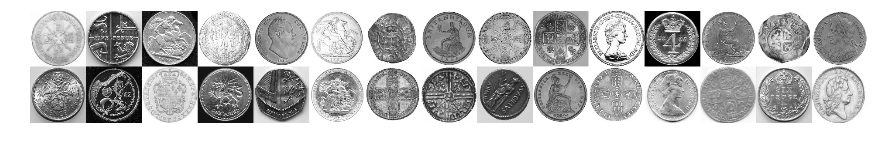

Test images:


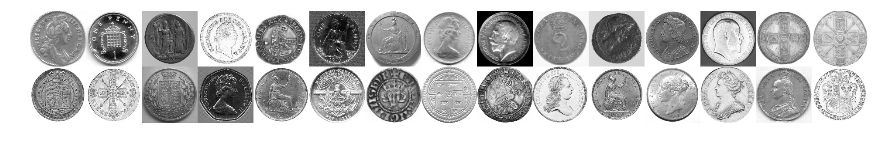

In [4]:
def test_load_data(path, data_size):
    image_shape = [128, 128, 1]
    data        = Dataset(image_shape)
    train_images, test_images, file_num = data.load(path, data_size)

    print("File num   :", file_num)
    print("Data size  :", data_size)
    print("Train shape:", list(train_images.shape))
    print("Test  shape:", list(test_images.shape))
    print("Image shape:", image_shape)
    print()
    print("Train images:")
    show_images(train_images, image_shape, rows=2, cols=15)
    print("Test images:")
    show_images(test_images, image_shape, rows=2, cols=15)

if global_run_tests:
    test_load_data(path=_dataset_path, data_size=42)

### Test batching

path     : /netforge/datasets/private/roman/coins/images
data_size: 100
['       1', '       0', '       1', '       0', '       1', '       0', '       1', '       0']


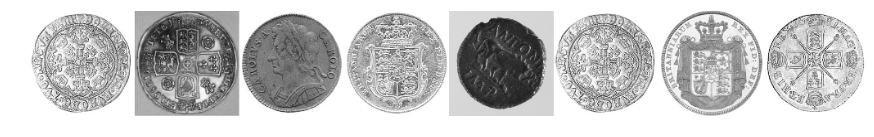

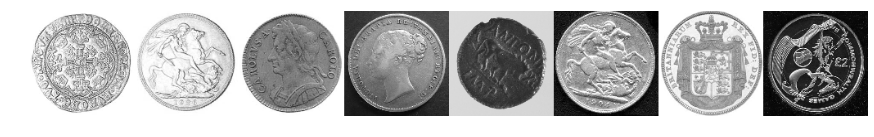

In [7]:
def test_batching(path, data_size, augment):
    data = Dataset(image_shape=[128, 128, 1])
    data.load(path, data_size)

    train_images   = data.train_images
    image_shape    = data.image_shape
    get_next_batch = data.get_next_batch
    
    n = 8
    im1, im2, lbl = get_next_batch(n, augment)
    lbl = lbl[:,1]
    print("path     :", data.path)
    print("data_size:", data_size)
    print(["%8d"%lbl[i] for i in range(len(im1))])
    show_images(im1, image_shape, cols=n, rows=1)
    show_images(im2, image_shape, cols=n, rows=1)
    
if global_run_tests:
    test_batching(path=_dataset_path, data_size=100, augment=None)